<figure>
  <IMG SRC="https://raw.githubusercontent.com/mbakker7/exploratory_computing_with_python/master/tudelft_logo.png" WIDTH=200 ALIGN="right">
</figure>

### InSAR data model based on xarray(/dask)

**Steps:**
- Load a raw interferogram (complex(Re, Im)) in binary format into a `xarray.Dataset` object
- Visualize the phase
- Load raw coherence into a `xarray.Dataset` object

In [1]:
# import sarxarray
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from tqdm import tqdm
from skimage.util import view_as_windows
import xarray as xr

In [2]:
import numpy as np

# Standard data types in sarxarray:
_dtypes = dict(int=np.int32, float=np.float32, complex=np.complex64)

In [3]:
import numpy as np
import xarray as xr
import dask.array as da
import warnings


@xr.register_dataset_accessor("slcstack")
class Stack:
    def __init__(self, xarray_obj):
        self._obj = xarray_obj

    def _get_amplitude(self):
        meta_arr = np.array((), dtype=_dtypes["float"])
        amplitude = da.apply_gufunc(
            _compute_amp, "()->()", self._obj.complex, meta=meta_arr
        )
        self._obj = self._obj.assign(
            {"amplitude": (("azimuth", "range", "time"), amplitude)}
        )
        return self._obj

    def _get_phase(self):
        meta_arr = np.array((), dtype=_dtypes["float"])
        phase = da.apply_gufunc(
            _compute_phase, "()->()", self._obj.complex, meta=meta_arr
        )
        self._obj = self._obj.assign({"phase": (("azimuth", "range", "time"), phase)})
        return self._obj

    def mrm(self):
        t_order = list(self._obj.dims.keys()).index("time")  # Time dimension order
        return self._obj.amplitude.mean(axis=t_order)

    def point_selection(self, threshold, method="amplitude_dispersion", chunks=1000):
        """
        Select pixels from a Stack, and return a Space-Time Matrix.

        The selection method is defined by `method` and `threshold`. The selected pixels will be reshaped to (points, time), where `points` is the number of selected pixels. The unselected pixels will be discarded. The original `azimuth` and `range` coordinates will be persisted.

        Parameters
        ----------
        threshold : float
            Threshold value for selection
        method : str, optional
            Method of selection, by default "amplitude_dispersion"
        chunks : int, optional
            Chunk size in the points dimension, by default 1000

        Returns
        -------
        xarray.Dataset
            An xarray.Dataset with two dimensions: (points, time).
        """

#         match method:
#             case "amplitude_dispersion":
#                 mask = self._amp_disp() < threshold
#             case other:
#                 raise NotImplementedError

        # Get the 1D index on points dimension
        mask_1d = mask.stack(points=("azimuth", "range")).drop_vars(
            ["azimuth", "range", "points"]
        )
        index = mask_1d.points.data[mask_1d.data]  # Evaluate the mask

        # Reshape from Stack ("azimuth", "range", "time") to Space-Time Matrix ("points", "time")
        stacked = self._obj.stack(points=("azimuth", "range"))
        stm = stacked.drop_vars(["points"])  # this will also drop azimuth and range
        stm = stm.assign_coords(
            {
                "azimuth": (["points"], stacked.azimuth.data),
                "range": (["points"], stacked.range.data),
            }
        )  # keep azimuth and range index

        # Apply selection
        stm_masked = stm.sel(points=index)

        # Re-order the dimensions to community preferred ("points", "time") order
        # Since there are dask arrays in stm_masked, this operation is lazy. Therefore its effect can be observed after evaluation
        stm_masked = stm_masked.transpose("points", "time")

        # Rechunk
        # Rechunk is needed because after apply maksing, the chunksize will be in consistant
        stm_masked = stm_masked.chunk(
            {
                "points": chunks,
                "time": -1,
            }
        )

        return stm_masked

    def _amp_disp(self, chunk_azimuth=500, chunk_range=500):
        # Time dimension order
        t_order = list(self._obj.dims.keys()).index("time")

        # Rechunk to make temporal operation more efficient
        amplitude = self._obj.amplitude.chunk(
            {"azimuth": chunk_azimuth, "range": chunk_range, "time": -1}
        )

        amplitude_dispersion = amplitude.std(axis=t_order) / (
            amplitude.mean(axis=t_order) + np.finfo(amplitude.dtype).eps
        )  # adding epsilon to avoid zero division

        return amplitude_dispersion


def _compute_amp(complex):
    return np.abs(complex)


def _compute_phase(complex):
    return np.angle(complex)


C:\Users\gdvdb\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
import logging

import dask
import numpy as np
import xarray as xr
import dask.array as da
import math

logger = logging.getLogger(__name__)

# Example: https://docs.dask.org/en/stable/array-creation.html#memory-mapping


def from_binary(
    slc_files, shape, vlabel="complex", dtype=np.float32, chunks=(-1, -1), ratio=1
):
    """
    Read a SLC stack or relabted variables from binary files

    Parameters
    ----------
    slc_files : Iterable
        Paths to the SLC files.
    shape : Tuple
        Shape of each SLC file, in (n_azimuth, n_range)
    vlabel : str, optional
        Name of the variable to read, by default "complex".
    dtype : numpy.dtype, optional
        Data type of the file to read, by default np.float32
    chunks : list, optional
        2-D chunk size, by default [-1, -1]
    ratio:
        Ratio of resolutions (azimuth/range), by default 1

    Returns
    -------
    xarray.Dataset
        An xarray.Dataset with three dimensions: (azimuth, range, time).

    """

    # Check dtype
    if not np.dtype(dtype).isbuiltin:
        if not all([name in (("re", "im")) for name in dtype.names]):
            raise TypeError(
                (
                    "The customed dtype should have only two field names: "
                    '"re" and "im". For example: '
                    'dtype = np.dtype([("re", np.float32), ("im", np.float32)]).'
                )
            )

    # Initialize stack as a Dataset
    coords = {
        "azimuth": range(shape[0]),
        "range": range(shape[1]),
        "time": range(len(slc_files)),
    }
    stack = xr.Dataset(coords=coords)

    # Calculate appropriate chunk size if not user-defined
    if -1 in chunks:
        chunks = _calc_chunksize(shape, dtype, chunks, ratio)

    # Read in all SLCs
    slcs = None
    for f_slc in slc_files:
        if slcs is None:
            slcs = read_slc(f_slc, shape, dtype, chunks).reshape(
                (shape[0], shape[1], 1)
            )
        else:
            slc = read_slc(f_slc, shape, dtype, chunks).reshape((shape[0], shape[1], 1))
            slcs = da.concatenate([slcs, slc], axis=2)

    # unpack the customized dtype
    if not np.dtype(dtype).isbuiltin:
        meta_arr = np.array((), dtype=_dtypes["complex"])
        slcs = da.apply_gufunc(_unpack_complex, "()->()", slcs, meta=meta_arr)

    stack = stack.assign({vlabel: (("azimuth", "range", "time"), slcs)})

    # If reading complex data, automatically
    if vlabel == "complex":
        stack = stack.slcstack._get_amplitude()
        stack = stack.slcstack._get_phase()

    return stack


def read_slc(filename_or_obj, shape, dtype, chunks):
    slc = _mmap_dask_array(
        filename=filename_or_obj, shape=shape, dtype=dtype, chunks=chunks
    )

    return slc


def _mmap_dask_array(filename, shape, dtype, chunks):
    """
    Create a Dask array from raw binary data in :code:`filename`
    by memory mapping.

    This method is particularly effective if the file is already
    in the file system cache and if arbitrary smaller subsets are
    to be extracted from the Dask array without optimizing its
    chunking scheme.

    It may perform poorly on Windows if the file is not in the file
    system cache. On Linux it performs well under most circumstances.

    Parameters
    ----------

    filename : str
    shape : tuple
        Total shape of the data in the file
    dtype:
        NumPy dtype of the data in the file
    chunks : int, optional
        Chunk size for the outermost axis. The other axes remain unchunked.

    Returns
    -------

    dask.array.Array
        Dask array matching :code:`shape` and :code:`dtype`, backed by
        memory-mapped chunks.
    """
    load = dask.delayed(_mmap_load_chunk)
    range_chunks = []
    for azimuth_index in range(0, shape[0], chunks[0]):
        azimuth_chunks = []
        # Truncate the last chunk if necessary
        azimuth_chunk_size = min(chunks[0], shape[0] - azimuth_index)
        for range_index in range(0, shape[1], chunks[1]):
            # Truncate the last chunk if necessary
            range_chunk_size = min(chunks[1], shape[1] - range_index)
            chunk = dask.array.from_delayed(
                load(
                    filename,
                    shape=shape,
                    dtype=dtype,
                    sl1=slice(azimuth_index, azimuth_index + azimuth_chunk_size),
                    sl2=slice(range_index, range_index + range_chunk_size),
                ),
                shape=(azimuth_chunk_size, range_chunk_size),
                dtype=dtype,
            )
            azimuth_chunks.append(chunk)
        range_chunk = da.concatenate(azimuth_chunks, axis=1)
        range_chunks.append(range_chunk)
    return da.concatenate(range_chunks, axis=0)


def _mmap_load_chunk(filename, shape, dtype, sl1, sl2):
    """
    Memory map the given file with overall shape and dtype and return a slice
    specified by :code:`sl`.

    Parameters
    ----------

    filename : str
    shape : tuple
        Total shape of the data in the file
    dtype:
        NumPy dtype of the data in the file
    sl:
        Object that can be used for indexing or slicing a NumPy array to
        extract a chunk

    Returns
    -------

    numpy.memmap or numpy.ndarray
        View into memory map created by indexing with :code:`sl`,
        or NumPy ndarray in case no view can be created using :code:`sl`.
    """
    data = np.memmap(filename, mode="r", shape=shape, dtype=dtype)
    return data[sl1, sl2]


def _unpack_complex(complex):
    return complex["re"] + 1j * complex["im"]


def _calc_chunksize(shape, dtype, chunks, ratio):
    """
    Calculate an optimal chunking size in the azimuth and range direction for
    reading with dask and store it in variable `chunks`

    Parameters
    ----------

    shape : tuple
        Total shape of the data in the file
    dtype:
        NumPy dtype of the data in the file
    ratio:
        Ratio of resolutions (azimuth/range)

    Returns
    -------

    chunks: tuple
        Chunk sizes (as multiples of 1000) in the azimuth and range direction.
        Default value of [-1, -1] when unmodified activates this function.
    """

    n_elements = (
        100 * 1024 * 1024 / np.dtype(dtype).itemsize
    )  # Optimal number of elements for a memory size of 200mb (first number)
    chunks_az = (
        int(math.ceil((n_elements * ratio) ** 0.5 / 1000.0)) * 1000
    )  # Chunking size in azimuth direction up to nearest thousand
    chunks_ra = (
        int(math.ceil(n_elements / chunks_az / 1000.0)) * 1000
    )  # Chunking size in range direction up to nearest thousand

    chunks = (chunks_az, chunks_ra)

    # Raise warning when chunk sizes are too large
    if chunks[0] * chunks[1] / (shape[0] * shape[1]) > 0.1:
        logger.warning(
            (
                "The default chunking mechanism is too large for given file. "
                "User-defined chunks is advised."
            )
        )
    return chunks


**Specify path of file location**

In [5]:
path = Path()  # CHANGE to local data directory

### Interferogram

**List the interferograms (.raw files) to be read**

In [6]:
f_ifg = 'cint_srd.raw'  # string

list_ifgs = [p/f_ifg for p in path.rglob("????????")]
list_ifgs[3:] = [Path(str(ifgs)[:len(str(ifgs))-len(f_ifg)]) for ifgs in list_ifgs[3:]]
list_ifgs

[WindowsPath('delft_tsx_asc_2016_3images/delft_tsx_asc_2016_3images/stack/20160321/cint_srd.raw'),
 WindowsPath('delft_tsx_asc_2016_3images/delft_tsx_asc_2016_3images/stack/20160412/cint_srd.raw'),
 WindowsPath('delft_tsx_asc_2016_3images/delft_tsx_asc_2016_3images/stack/20160504/cint_srd.raw'),
 WindowsPath('delft_tsx_asc_2016_3images/delft_tsx_asc_2016_3images/stack/20160321/ifgs.res'),
 WindowsPath('delft_tsx_asc_2016_3images/delft_tsx_asc_2016_3images/stack/20160412/ifgs.res'),
 WindowsPath('delft_tsx_asc_2016_3images/delft_tsx_asc_2016_3images/stack/20160504/ifgs.res')]

In [7]:
# Create list with dates
# Mother = 20180108

date_list = []
for i in range(len(list_ifgs)):
    prep_date_string = str(list_ifgs[i])
    date = prep_date_string.split('\\')[3]
    date_list.append(date)
date_list

['20160321', '20160412', '20160504', '20160321', '20160412', '20160504']

In [8]:
# Take the mother-mother ifg out

mother_str = '20160321'
mother_idx = date_list.index(mother_str)


list_ifgs_without_mother = list_ifgs[0:mother_idx]+list_ifgs[(mother_idx+1):10]
list_ifgs_without_mother

[WindowsPath('delft_tsx_asc_2016_3images/delft_tsx_asc_2016_3images/stack/20160412/cint_srd.raw'),
 WindowsPath('delft_tsx_asc_2016_3images/delft_tsx_asc_2016_3images/stack/20160504/cint_srd.raw'),
 WindowsPath('delft_tsx_asc_2016_3images/delft_tsx_asc_2016_3images/stack/20160321/ifgs.res'),
 WindowsPath('delft_tsx_asc_2016_3images/delft_tsx_asc_2016_3images/stack/20160412/ifgs.res'),
 WindowsPath('delft_tsx_asc_2016_3images/delft_tsx_asc_2016_3images/stack/20160504/ifgs.res')]

**Metadata**

Information about the shape can be found in the ifgs.res files and are denoted using 'nlines' and 'npixels', respectively.

In [9]:
# Metadata

shape=(25, 25)  # obtained from ifgs.res --> nlines = rows ; npixels = columns
dtype = np.dtype([('re', np.float32), ('im', np.float32)])

**Loading the raw interferogram into a `xarray.Dataset`**

In [10]:
# Create xarray.Dataset object from .raw file

ifg_stack = from_binary(list_ifgs_without_mother, shape, dtype=dtype)
ifg_stack = ifg_stack.chunk({"azimuth":25, "range":25, "time":1 })  # set custom chunk sizes

ifg_stack

The default chunking mechanism is too large for given file. User-defined chunks is advised.


<xarray.Dataset>
Dimensions:    (azimuth: 25, range: 25, time: 5)
Coordinates:
  * azimuth    (azimuth) int32 0 1 2 3 4 5 6 7 8 ... 16 17 18 19 20 21 22 23 24
  * range      (range) int32 0 1 2 3 4 5 6 7 8 9 ... 16 17 18 19 20 21 22 23 24
  * time       (time) int32 0 1 2 3 4
Data variables:
    complex    (azimuth, range, time) complex64 dask.array<chunksize=(25, 25, 1), meta=np.ndarray>
    amplitude  (azimuth, range, time) float32 dask.array<chunksize=(25, 25, 1), meta=np.ndarray>
    phase      (azimuth, range, time) float32 dask.array<chunksize=(25, 25, 1), meta=np.ndarray>

In [11]:
phase = ifg_stack.phase
amplitude = ifg_stack.amplitude
phasor = ifg_stack.complex # contains P00, P01, P02

In [12]:
phase

<xarray.DataArray 'phase' (azimuth: 25, range: 25, time: 5)>
dask.array<transpose, shape=(25, 25, 5), dtype=float32, chunksize=(25, 25, 1), chunktype=numpy.ndarray>
Coordinates:
  * azimuth  (azimuth) int32 0 1 2 3 4 5 6 7 8 9 ... 16 17 18 19 20 21 22 23 24
  * range    (range) int32 0 1 2 3 4 5 6 7 8 9 ... 15 16 17 18 19 20 21 22 23 24
  * time     (time) int32 0 1 2 3 4

**Visualize the phase**

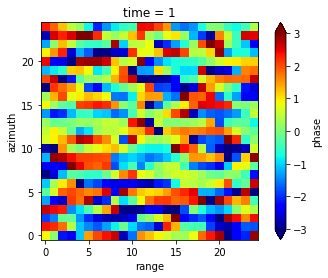

In [13]:
# Visualize first figure

fig,ax = plt.subplots(1,1)
phase_i = phase.isel(time=1)
ax.imshow(phase_i)
phase_i.plot(robust=True, ax=ax, cmap='jet')  # cmap='jet'

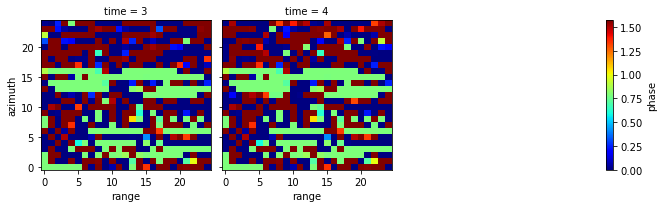

In [14]:
# Visualize 3/9 figures

phase_ex = ifg_stack.phase.isel(time=slice(3,6))  
phase_ex.plot(x="range", y="azimuth", col="time", col_wrap=3, cmap='jet')

100%|██████████| 5/5 [00:00<00:00, 11.79it/s]


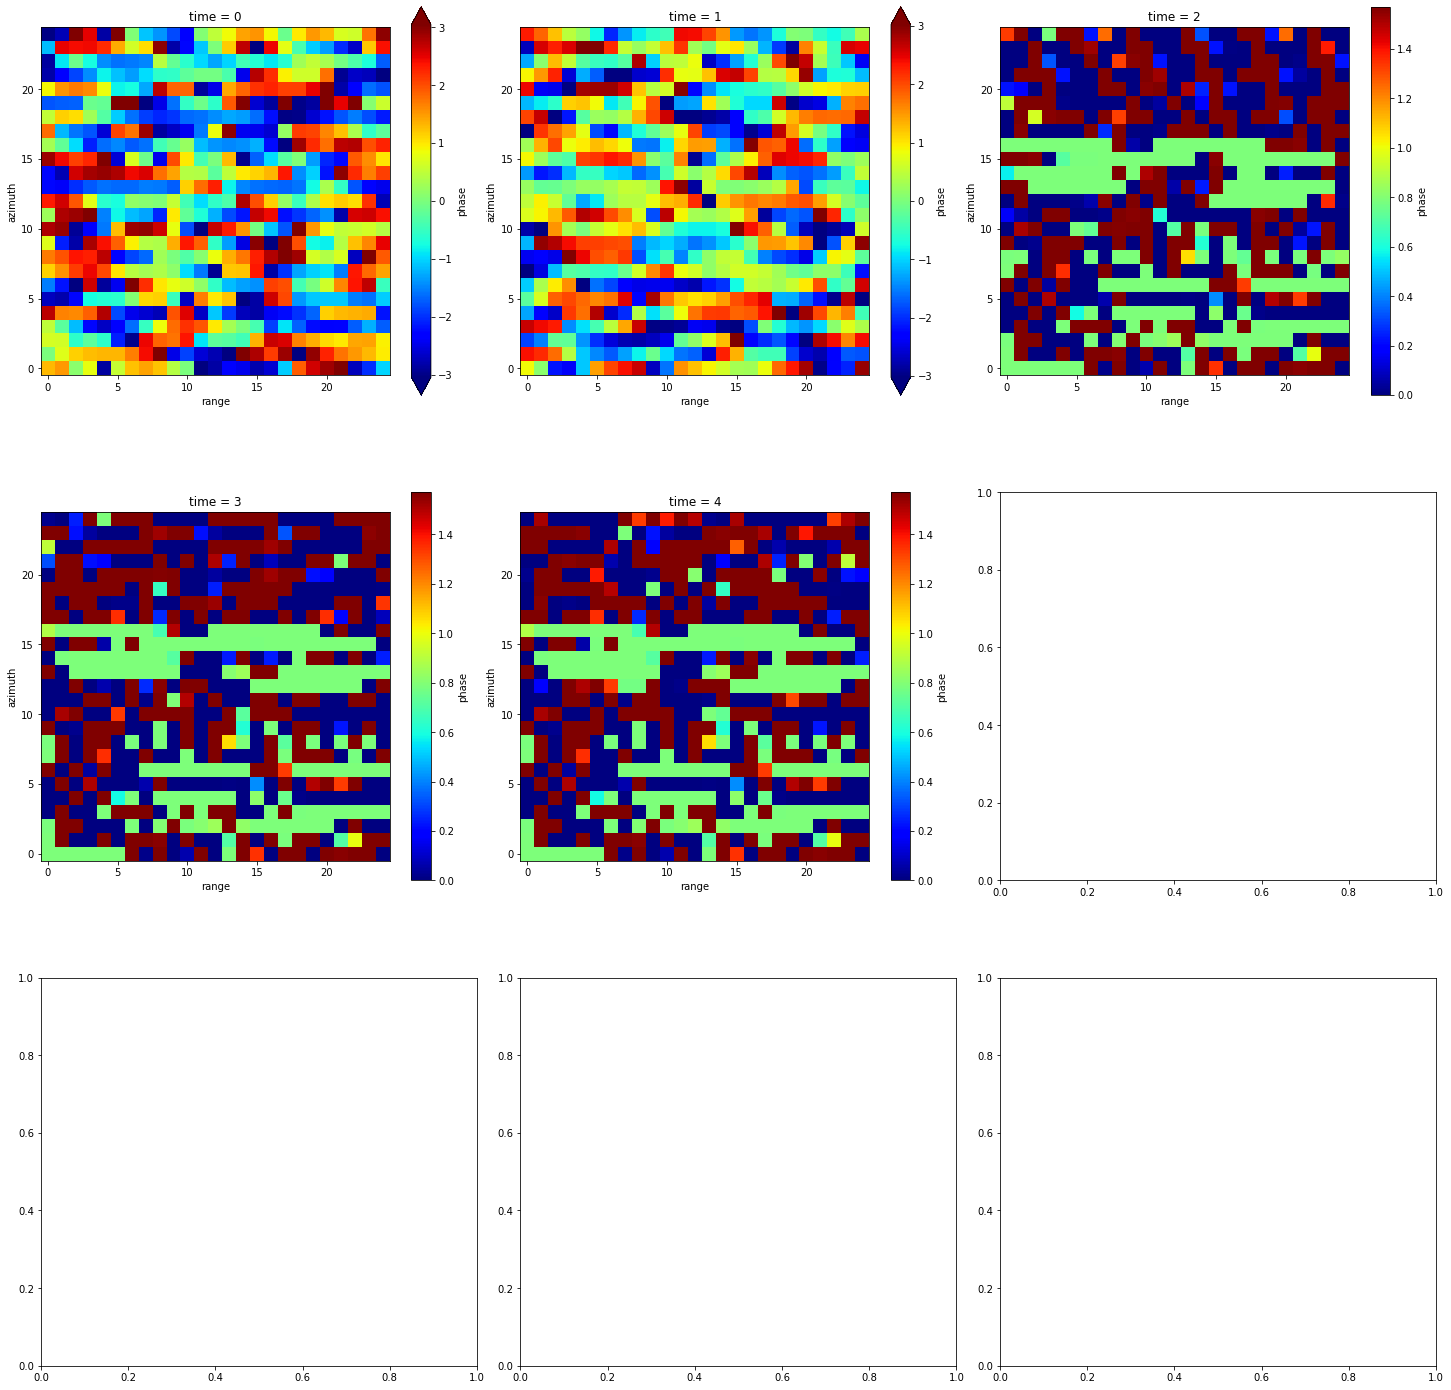

In [15]:
fig, axs = plt.subplots(3,3, figsize=(25, 25), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .25, wspace=.1)

axs = axs.ravel()

for i in tqdm(range(len(ifg_stack.time))):
    phase_i = phase.isel(time=i)
    axs[i].imshow(phase_i)
    phase_i.plot(robust=True, ax=axs[i], cmap='jet')  # cmap='jet'


**MRM (Mean Reflection Map)**

In [16]:
# Creating a MRM (Mean Reflection Map) of a subset of the stack

mrm = ifg_stack.slcstack.mrm() # go 3D to 2D --> only azimuth & range for amplitude
mrm

<xarray.DataArray 'amplitude' (azimuth: 25, range: 25)>
dask.array<mean_agg-aggregate, shape=(25, 25), dtype=float32, chunksize=(25, 25), chunktype=numpy.ndarray>
Coordinates:
  * azimuth  (azimuth) int32 0 1 2 3 4 5 6 7 8 9 ... 16 17 18 19 20 21 22 23 24
  * range    (range) int32 0 1 2 3 4 5 6 7 8 9 ... 15 16 17 18 19 20 21 22 23 24

In [19]:
mrm_subset = mrm[:, :]  # Create subset using 2 indexes: azimuth & range

mrm_subset = mrm_subset.compute() # manually trigger loading of this array’s data from disk or a remote source into memory and return a new array
mrm_subset

<xarray.DataArray 'amplitude' (azimuth: 25, range: 25)>
array([[8.01205750e+02, 3.94237091e+02, 1.50497345e+02, 3.14696411e+02,
        4.91581055e+02, 1.14973560e+03, 3.98756000e+05, 1.27146082e+11,
        5.08491825e+11, 1.05200078e+04, 6.54257301e+23, 4.28585577e+31,
        4.43807014e+20, 2.68653369e+03, 2.49858057e+03, 1.11814154e+31,
        1.67526392e+03, 1.09907062e+25, 4.38144602e+31, 3.22051487e+28,
        2.72689237e+30, 2.90480787e+30, 2.97421408e+33, 2.72548155e+30,
        1.11141592e+28],
       [1.86390625e+03, 2.72697095e+30, 1.11141592e+28, 4.79213892e+20,
        1.76356519e+03, 1.15421387e+03, 6.77361712e+26, 1.57872425e+06,
        2.35413818e+03, 1.44901343e+03, 4.57179864e+31, 6.54060007e+26,
        4.65217256e+26, 6.07218018e+03, 1.16525047e+31, 2.28245698e+13,
        2.67926069e+30, 2.33499854e+03, 1.22040384e+32, 2.66798096e+03,
        4.65080492e+26, 3.44033984e+03, 2.96882373e+03, 2.77679872e+27,
        4.28072654e+31],
       [7.91013855e+02, 2.53752788e+21, 1.92595566e+02, 2.47526566e+02,
        3.77817171e+34, 2.51690505e+21, 1.14739880e+03, 1.88642261e+03,
        5.99601193e+22, 4.28073186e+31, 1.17680530e+03, 9.97217407e+02,
        2.15372021e+03, 2.30932617e+03, 1.28459985e+03, 3.11114044e+02,
        7.57933777e+02, 5.24492676e+02, 5.17151855e+02, 7.31683960e+02,
        9.07277527e+02, 1.72188784e+36, 1.10821121e+25, 4.32909010e+22,
...
        5.17990381e+03, 8.16673926e+03, 6.64870947e+03, 2.36325269e+03,
        7.44935425e+02, 1.98861450e+03, 3.61320850e+03, 3.35794067e+03,
        1.79709216e+03, 1.34336890e+03, 1.33002661e+03, 1.67719531e+03,
        2.21128979e+03, 1.25131812e+03, 9.14380493e+02, 1.74731274e+03,
        2.17269946e+03, 3.08014453e+03, 3.63065942e+03, 1.48744275e+03,
        4.67983246e+02],
       [6.19517456e+02, 2.69798950e+03, 7.53644434e+03, 8.93974512e+03,
        6.85424072e+03, 4.04821875e+03, 3.95321167e+03, 2.45523291e+03,
        3.07039111e+03, 2.13351709e+03, 1.16373193e+03, 1.08259656e+03,
        9.89137512e+02, 8.51325806e+02, 5.36624817e+02, 1.05547083e+03,
        1.12607593e+03, 8.77361938e+02, 1.73459351e+03, 1.47275659e+03,
        1.50494568e+03, 7.13292297e+02, 2.23711914e+02, 6.65675293e+02,
        9.82125793e+02],
       [1.69497131e+03, 2.41018335e+03, 2.02870044e+03, 1.66819141e+03,
        1.31558533e+03, 2.82469421e+02, 1.20755396e+03, 2.25015430e+03,
        2.52494556e+03, 1.66195862e+03, 5.54200684e+02, 1.01189896e+02,
        3.72966370e+02, 4.14301819e+02, 3.01873688e+02, 1.77703323e+02,
        1.43006516e+02, 1.63202866e+02, 2.22782959e+02, 3.10550476e+02,
        3.12798004e+02, 2.25849701e+02, 2.82800934e+02, 3.17700043e+02,
        4.52066162e+02]], dtype=float32)
Coordinates:
  * azimuth  (azimuth) int32 0 1 2 3 4 5 6 7 8 9 ... 16 17 18 19 20 21 22 23 24
  * range    (range) int32 0 1 2 3 4 5 6 7 8 9 ... 15 16 17 18 19 20 21 22 23 24

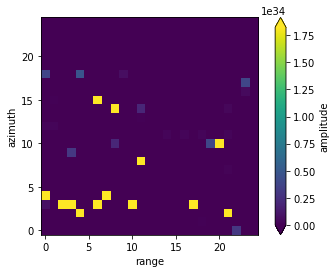

In [20]:
# Visualize

fig, ax = plt.subplots()
ax.imshow(mrm_subset)
mrm_subset.plot(robust=True, ax=ax)

**Load raw coherence**

In [21]:
f_coh = 'coherence.raw'  # string

list_coh = [p/f_coh for p in path.rglob("????????")]
list_coh = list_coh[0:mother_idx] + list_coh[mother_idx+1:10]  # do not include coherence of mother-mother ifg

In [25]:
# Metadata

shape=(25, 25)  # obtained from ifgs.res --> nlines = rows ; npixels = columns

# Create xarray.Dataset object from .raw file

coh_stack = from_binary(list_coh, shape, dtype=np.float32)
coh_stack = coh_stack.chunk({"azimuth":25, "range":25, "time":1 })  # set custom chunk sizes
coh_stack

The default chunking mechanism is too large for given file. User-defined chunks is advised.


<xarray.Dataset>
Dimensions:    (azimuth: 25, range: 25, time: 5)
Coordinates:
  * azimuth    (azimuth) int32 0 1 2 3 4 5 6 7 8 ... 16 17 18 19 20 21 22 23 24
  * range      (range) int32 0 1 2 3 4 5 6 7 8 9 ... 16 17 18 19 20 21 22 23 24
  * time       (time) int32 0 1 2 3 4
Data variables:
    complex    (azimuth, range, time) float32 dask.array<chunksize=(25, 25, 1), meta=np.ndarray>
    amplitude  (azimuth, range, time) float32 dask.array<chunksize=(25, 25, 1), meta=np.ndarray>
    phase      (azimuth, range, time) float32 dask.array<chunksize=(25, 25, 1), meta=np.ndarray>

  0%|          | 0/5 [00:00<?, ?it/s]

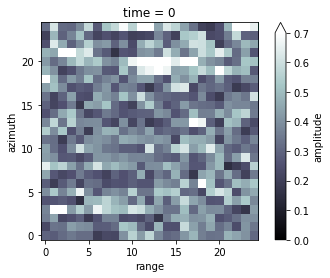

 20%|██        | 1/5 [00:00<00:01,  2.11it/s]

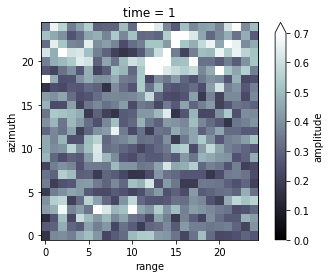

 40%|████      | 2/5 [00:00<00:01,  2.09it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'delft_tsx_asc_2016_3images\\delft_tsx_asc_2016_3images\\stack\\20160321\\ifgs.res\\coherence.raw'

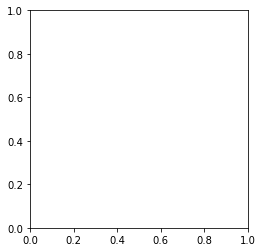

In [26]:
# Visualize coherence

fig,ax = plt.subplots(1,1)

for i in tqdm(range(len(coh_stack.time))):
    coh_i = coh_stack.amplitude.isel(time=i)
    plt.imshow(coh_i)
    coh_i.plot(robust=True, cmap='bone',vmax=0.7,vmin=0)  # cmap='jet'
    plt.show() 

**Load slave_rsmp - to get original amplitude of SLC's e.g.**

In [29]:
path_mother = Path('data_mother')  
f_mother = 'slave_rsmp.raw'  # Load complex data of mother to obtain amplitude

shape=(25, 25)  # obtained from ifgs.res --> nlines = rows ; npixels = columns
dtype = np.dtype([('re', np.float32), ('im', np.float32)])

mother = [p/f_mother for p in path_mother.rglob("????????")]

mother = from_binary(mother, shape, dtype=dtype)
mother = mother.chunk({"azimuth":25, "range":25, "time":1 })  # set custom chunk sizes
mother.amplitude

The default chunking mechanism is too large for given file. User-defined chunks is advised.


ValueError: Could not convert tuple of form (dims, data[, attrs, encoding]): (('azimuth', 'range', 'time'), dask.array<transpose, shape=(), dtype=complex64, chunksize=(), chunktype=numpy.ndarray>) to Variable.

**Multi-looking**

In [30]:
def multilooking(data, window_size, variable_name):
    
    # Generate patches
    
    patches_real = view_as_windows(np.real(data), window_size, step=window_size)  # step is important as its value can result in overlapping or non overlapping patches
    
    # Compute the mean of each patch
    
    real_mean = np.nanmean(patches_real, axis=(2, 3))  # the 3rd and 4th axes represent the window dimensions
    
    # Consider the imaginary part; in the case input data is a complex number
    
    if not np.all(np.imag(data) == 0):  # if imaginary
        
        patches_imag = view_as_windows(np.imag(data), window_size, step=window_size)
        
        # Compute the mean of each patch
        
        imag_mean = np.nanmean(patches_imag, axis=(2, 3))
        
        # Combine the real and imaginary part
        
        output_array = real_mean + 1j * imag_mean
        
        # Save as xarray dataset
        
        comp = xr.DataArray(output_array, dims=None)
        ph = xr.DataArray(np.angle(output_array), dims=('azimuth','range'))
        amp = xr.DataArray(np.abs(output_array), dims=('azimuth','range'))
        
        output_array = xr.DataArray(comp, 
                        coords={'azimuth': np.arange(0, np.shape(output_array)[0], 1, dtype=int),
                        'range': np.arange(0, np.shape(output_array)[1], 1, dtype=int)}, 
                        dims=["azimuth","range"])
        output_array= output_array.to_dataset(name='complex')

        output_array['amplitude'] = amp
        output_array['phase'] = ph
        
    else:
        
        output_array = real_mean
        
        # Save as xarray dataset
        
        output_array = xr.DataArray(output_array, 
                        coords={'azimuth': np.arange(0, np.shape(output_array)[0], 1, dtype=int),
                        'range': np.arange(0, np.shape(output_array)[1], 1, dtype=int)}, 
                        dims=["azimuth","range"])
        output_array = output_array.to_dataset(name=variable_name)
        
    return output_array

In [31]:
# Apply multilooking

first_skip = False
count = 0
coords = []

window_size = (22,10)

ifg_ml0 = multilooking(ifg_stack.complex.isel(time=0).values, window_size=window_size, variable_name='complex')

for i in range(len(ifg_stack.time)):
    if(first_skip):
        toAdd_ifg = multilooking(ifg_stack.complex.isel(time=i).values, window_size=window_size, variable_name='complex')
        ifg_ml0 = xr.concat([ifg_ml0, toAdd_ifg], dim="time")
    first_skip = True 
    
    coords.append(count)
    count+=1 
    
ifg_ml = ifg_ml0.assign_coords(time=coords)

  0%|          | 0/5 [00:00<?, ?it/s]


AttributeError: 'Line2D' object has no property 'robust'

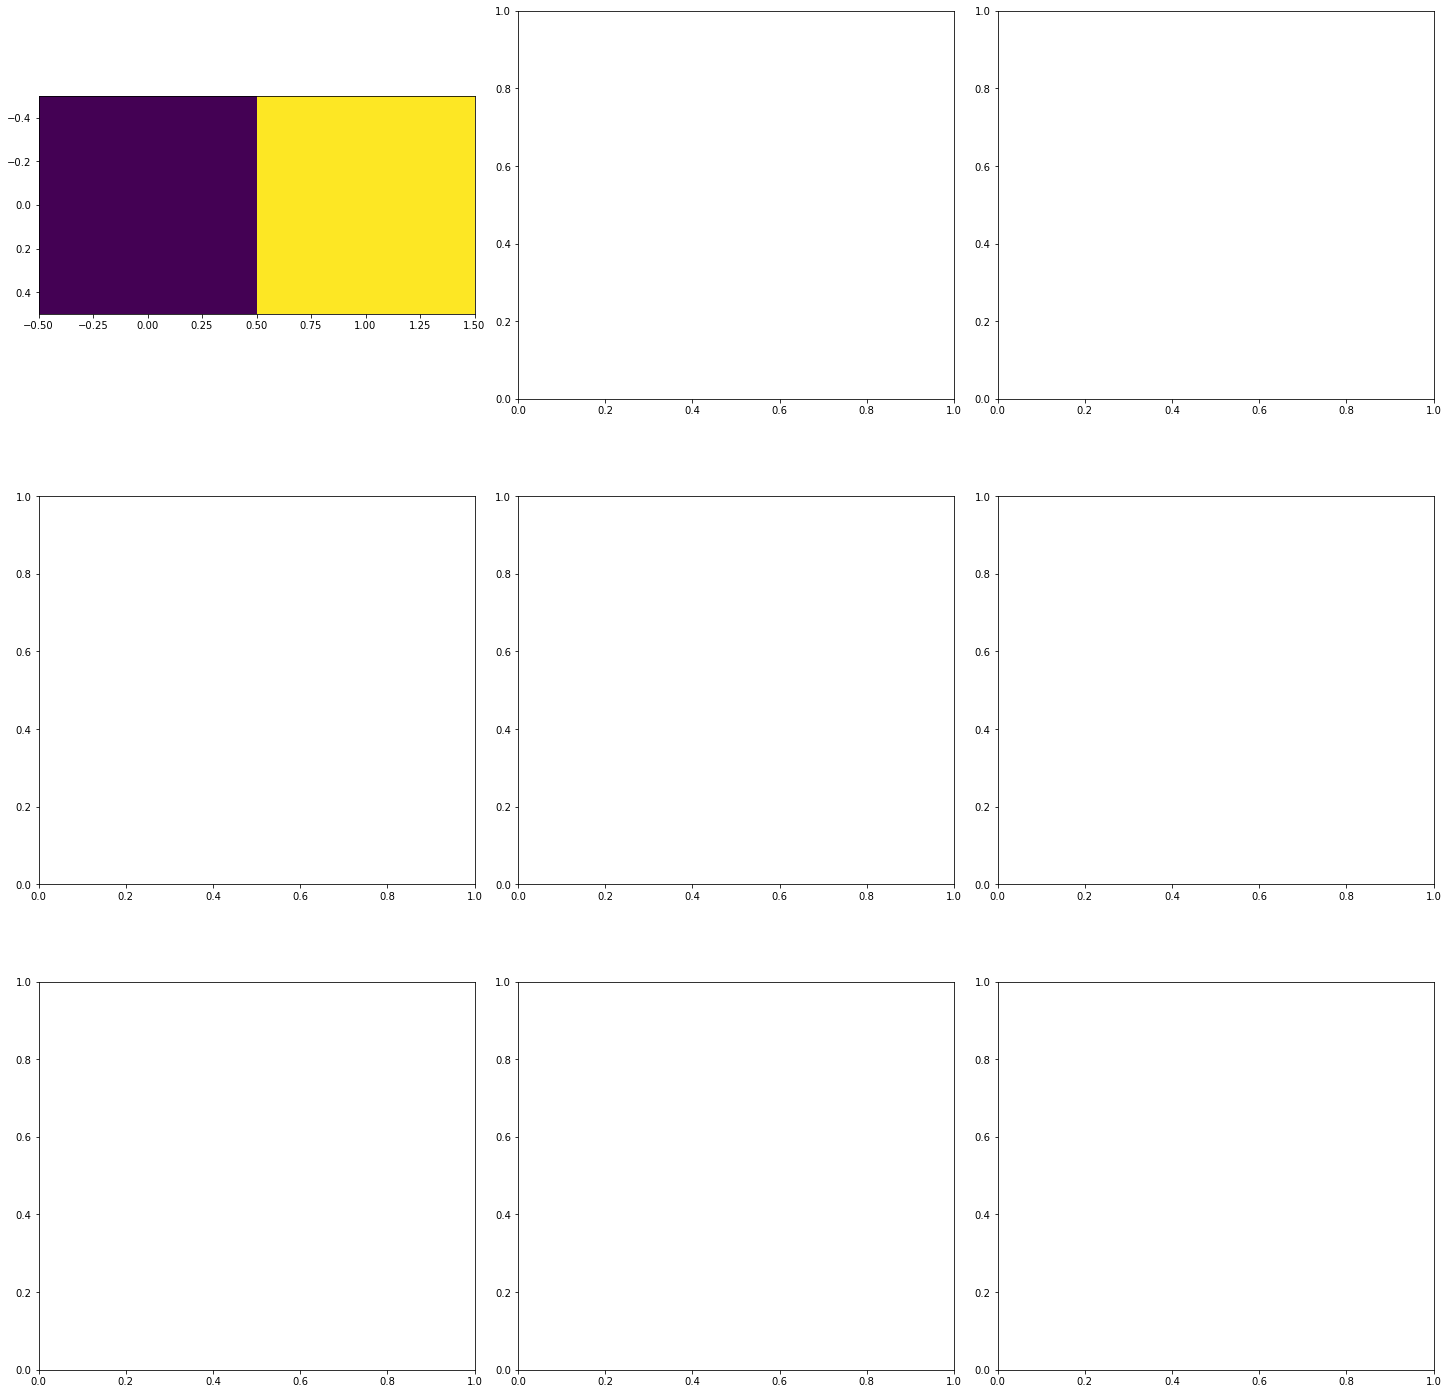

In [32]:
fig, axs = plt.subplots(3,3, figsize=(25, 25), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .25, wspace=.1)

axs = axs.ravel()

for i in tqdm(range(len(ifg_ml.time))):
    axs[i].imshow(ifg_ml.phase.isel(time=i))
    ifg_ml.phase.isel(time=i).plot(robust=True, ax=axs[i], cmap='jet')  # cmap='jet'